In [21]:

# Import necessary libraries
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to preprocess images: Convert to grayscale and apply edge detection
def preprocess_image(image_path, target_size=(224, 224)):
    # Load image
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection (Canny)
    edges = cv2.Canny(gray, 100, 200)
    
    # Resize to match model input size
    edges = cv2.resize(edges, target_size)
    
    # Convert to 3 channels since ResNet expects RGB input
    edges = np.stack([edges]*3, axis=-1)
    
    # Normalize pixel values
    edges = edges / 255.0
    
    return edges

# Example usage
# processed_image = preprocess_image("sample_image.jpg")


### Importing required libraries

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [23]:
# Set dataset path
TRAIN_PATH = r'D:\IIT\Subjects\(4605)IRP\Devlo\Augmented_DataSet_Split\train'
VAL_PATH = r'D:\IIT\Subjects\(4605)IRP\Devlo\Augmented_DataSet_Split\val'
TEST_PATH = r'D:\IIT\Subjects\(4605)IRP\Devlo\Augmented_DataSet_Split\test'

In [24]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

### Initializing train, validation & test data

In [25]:
# Data Generators
train_gen = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    VAL_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6698 images belonging to 4 classes.
Found 1914 images belonging to 4 classes.
Found 958 images belonging to 4 classes.


### Plot Images with labels

In [26]:
# Get class labels
class_labels = list(train_gen.class_indices.keys())
print("Class Labels:", class_labels)

Class Labels: ['healthy', 'live_wood', 'pink_wax', 'stem_canker']


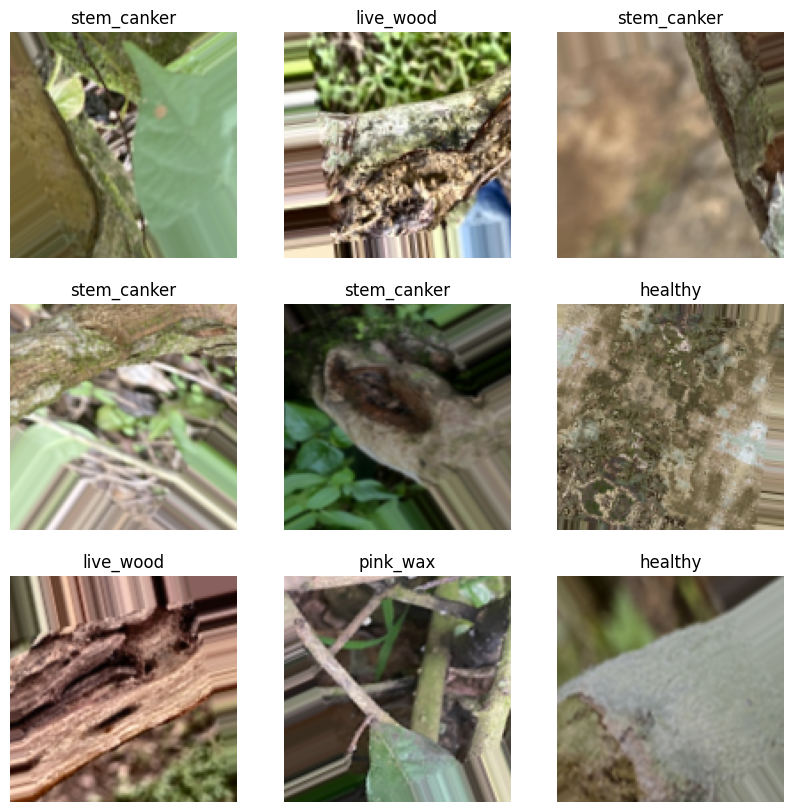

In [27]:
# Visualize Some Images
def visualize_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis("off")
    plt.show()

visualize_images(train_gen)

In [28]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152V2

def create_hybrid_cnn_resnet152v2(input_shape=(128, 128, 3), num_classes=4):
    # CNN part
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)  # Smooth output for merging

    # ResNet152V2 part
    resnet_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=input_shape)
    resnet_base.trainable = False  # Freeze ResNet layers initially
    
    # Unfreeze last 15 layers for fine-tuning
    for layer in resnet_base.layers[-15:]:
        layer.trainable = True

    # Pass original input to ResNet
    resnet_features = resnet_base(inputs)
    resnet_features = layers.GlobalAveragePooling2D()(resnet_features)

    # Combine CNN and ResNet features
    concatenated = layers.Concatenate()([x, resnet_features])

    # Fully connected layers
    x = layers.Flatten()(concatenated)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Build the model
    model = models.Model(inputs, outputs)
    return model

# Create and summarize the hybrid model
hybrid_model = create_hybrid_cnn_resnet152v2()
hybrid_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152v2         │ (None, 4, 4,      │ 58,331,648 │ input_layer_4[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv2d_7[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet152v2[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2304)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2304)      │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │  1,180,160 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]   

 Total params: 60,064,964 (229.13 MB)

 Trainable params: 7,252,676 (27.67 MB)

 Non-trainable params: 52,812,288 (201.46 MB)

ResNet50


In [29]:
# Model Initialization
ResNet_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

In [30]:
model = Sequential([
    ResNet_model,
    GlobalAveragePooling2D(),
    Dense(units=512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(train_gen.num_classes, activation='softmax')
])


model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 4, 4, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,645,444 (227.53 MB)

 Trainable params: 6,833,156 (26.07 MB)

 Non-trainable params: 52,812,288 (201.46 MB)

In [31]:
# Compile Model
hybrid_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [32]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, patience=3, min_lr=0.0001)
checkpoint = ModelCheckpoint('resnet_hybride_gray.keras', monitor='val_accuracy', save_best_only=True)


In [33]:
# Training
history = hybrid_model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.4540 - loss: 1.2303 - precision_1: 0.6424 - recall_1: 0.2235 - val_accuracy: 0.6766 - val_loss: 0.9892 - val_precision_1: 0.7479 - val_recall_1: 0.6123 - learning_rate: 0.0010
Epoch 2/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.6634 - loss: 0.8374 - precision_1: 0.8241 - recall_1: 0.4935 - val_accuracy: 0.7079 - val_loss: 0.7707 - val_precision_1: 0.8134 - val_recall_1: 0.6196 - learning_rate: 0.0010
Epoch 3/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.7147 - loss: 0.7344 - precision_1: 0.8465 - recall_1: 0.5819 - val_accuracy: 0.7372 - val_loss: 0.7349 - val_precision_1: 0.8795 - val_recall_1: 0.5606 - learning_rate: 0.0010
Epoch 4/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.7223 - loss: 0.7057 - precision_1: 0.8530 - recall_1: 0.5920 - val_accuracy: 0.6970 - val_loss: 0.7032 - val_precision_1: 0.8275 - val_recall_1: 0.5841 - learning_rate: 0.0010
Epoch 5/30
210/210 ━━━━━━━━━

In [34]:
# Save Final Model
hybrid_model.save('resnet_hybride_gray.h5')

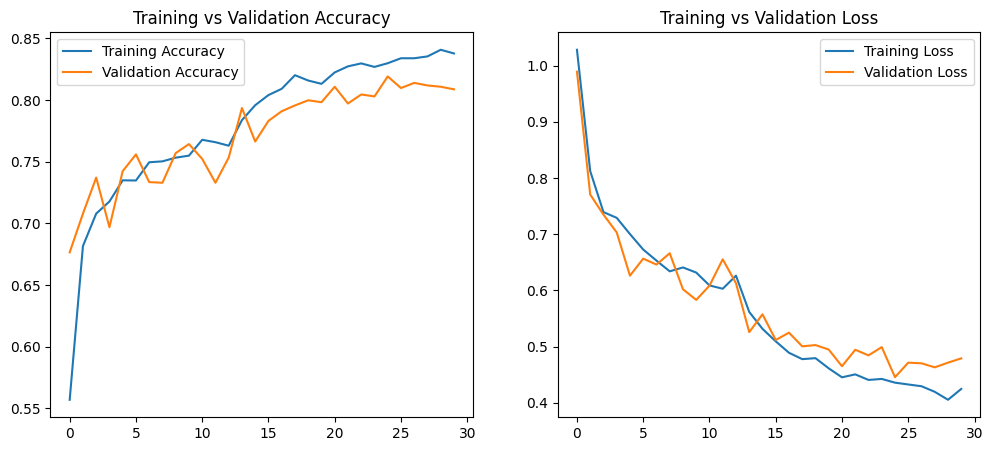

In [35]:
# Evaluation
# Plot Training vs Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] , label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [36]:
from keras.models import load_model

# Load the saved model
saved_model = load_model('resnet_hybride_gray.keras')

# Evaluate on training data
train_results = saved_model.evaluate(train_gen, verbose=0)
print(f"Training - Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]*100:.2f}%, Precision: {train_results[2]*100:.2f}%, Recall: {train_results[3]*100:.2f}%")

# Evaluate on validation data
val_results = saved_model.evaluate(val_gen, verbose=0)
print(f"Validation - Loss: {val_results[0]:.4f}, Accuracy: {val_results[1]*100:.2f}%, Precision: {val_results[2]*100:.2f}%, Recall: {val_results[3]*100:.2f}%")

# Evaluate on test data
test_results = saved_model.evaluate(test_gen, verbose=0)
print(f"Test - Loss: {test_results[0]:.4f}, Accuracy: {test_results[1]*100:.2f}%, Precision: {test_results[2]*100:.2f}%, Recall: {test_results[3]*100:.2f}%")


Training - Loss: 0.3798, Accuracy: 84.58%, Precision: 90.45%, Recall: 78.50%
Validation - Loss: 0.4818, Accuracy: 79.89%, Precision: 86.93%, Recall: 75.08%
Test - Loss: 0.4636, Accuracy: 80.69%, Precision: 87.97%, Recall: 75.57%


In [37]:
prediction_effnet = saved_model.predict(test_gen) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


In [38]:
true_labels = []

# Iterate only through the number of batches
for i in range(len(test_gen)):
    image_batch, label_batch = test_gen[i]
    true_labels.append(label_batch)

# Concatenate and convert to numpy
correct_labels = tf.concat(true_labels, axis=0).numpy()


In [39]:
print(type(prediction_effnet))
print(type(correct_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [40]:
from sklearn.metrics import classification_report
import numpy as np

# Convert one-hot encoded labels to class indices if needed
if correct_labels.ndim > 1:
    correct_labels = np.argmax(correct_labels, axis=1)

# Convert predictions to class indices if they are probabilities
if prediction_effnet.ndim > 1:
    prediction_effnet = np.argmax(prediction_effnet, axis=1)

# Ensure both arrays are integers
correct_labels = correct_labels.astype(int)
prediction_effnet = prediction_effnet.astype(int)

# Generate Classification Report
print(classification_report(correct_labels, prediction_effnet))


              precision    recall  f1-score   support

           0       0.82      0.72      0.77       250
           1       0.90      0.87      0.89       237
           2       0.77      0.90      0.83       236
           3       0.74      0.74      0.74       235

    accuracy                           0.81       958
   macro avg       0.81      0.81      0.81       958
weighted avg       0.81      0.81      0.81       958

